In [1]:
# Parametric PINNs for Navier-Stokes
# Aditya Jangir ( IIT Delhi )
# This Jupyter Notebook contains code to load the trained HybridPINNs model (LIDReHybridPINNs.keras) 
# It shows the comparison between Pure PINNs and Reference CFD solution.
# The CFD data were generated using OpenFOAM 12 
# and validated against reference data from the literature by Cortes and Miller (1993).
# The results generated using this code are reported in the paper
# “A Parameterized Physics-Informed Neural Network Solver for the Navier–Stokes Equations Across Reynolds Numbers”,
# Which is available on arXiv: arXiv:2602.04670 and is being prepared for submission to Physics of Fluids.

In [2]:
# import relevent libraries and packages

import numpy as np
import time
import os
import tensorflow as tf
import scipy.optimize as spo
import matplotlib.pyplot as plt
from matplotlib import cm
import subprocess
import torch
import pandas as pd
from scipy.interpolate import griddata


In [3]:
# Problem / numerical params
tf.random.set_seed(42); np.random.seed(42)
Re_min, Re_max = 5e2, 1e3  # Range of the Reynolds number for which model is going to train
x_min, x_max = 0.0, 1.0    # Define the domain
y_min, y_max = 0.0, 1.0
D_default = 10             # Hidden layers
N_default = 80             # Neurons per hidden layers
Nx_cells = 100             # Collocation poins = (Nx_cells)*(Ny_cells)
Ny_cells = 100
N_b_per_side = 1000        # Boundary points = 4*N_b_per_side


In [4]:
# Neural Network Architecture for Pure PINNs

class HybridPINN(tf.keras.Model):
    def __init__(self,
                 num_hidden_layers=D_default,
                 num_neurons_per_layer=N_default,
                 include_pressure=True,
                 activation='tanh',
                 kernel_regularizer=tf.keras.regularizers.L2(1e-8),
                 x_mean=0.5, x_scale=0.5,
                 y_mean=0.5, y_scale=0.5,
                 re_mean=np.log(5e2), re_scale=1.0,
                 use_log_re=True,
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.num_neurons_per_layer = num_neurons_per_layer
        self.include_pressure = include_pressure
        self.use_log_re = use_log_re

        # Normalization constants
        self.x_mean = tf.constant(x_mean, dtype=tf.float32)
        self.x_scale = tf.constant(x_scale, dtype=tf.float32)
        self.y_mean = tf.constant(y_mean, dtype=tf.float32)
        self.y_scale = tf.constant(y_scale, dtype=tf.float32)
        self.re_mean = tf.constant(re_mean, dtype=tf.float32)
        self.re_scale = tf.constant(re_scale, dtype=tf.float32)

        # Input normalization layer
        self.input_norm = tf.keras.layers.Lambda(self._normalize_inputs, name='input_norm')

        # Hidden layers
        hidden = []
        for i in range(num_hidden_layers):
            hidden.append(tf.keras.layers.Dense(num_neurons_per_layer,
                                                activation=activation,
                                                kernel_initializer='glorot_normal',
                                                kernel_regularizer=kernel_regularizer,
                                                name=f'dense_{i}'))
            hidden.append(tf.keras.layers.LayerNormalization(name=f'ln_{i}'))
        self.hidden_seq = tf.keras.Sequential(hidden, name='hidden_seq')

        # Output layers
        self.u_out = tf.keras.layers.Dense(1, activation=None, name='u_out')
        self.v_out = tf.keras.layers.Dense(1, activation=None, name='v_out')
        if self.include_pressure:
            self.p_out = tf.keras.layers.Dense(1, activation=None, name='p_out')
        else:
            self.p_out = None

    def _normalize_inputs(self, X):
        x = X[:, 0:1]
        y = X[:, 1:2]
        re = X[:, 2:3]

        x_n = (x - self.x_mean) / (self.x_scale + 1e-8)
        y_n = (y - self.y_mean) / (self.y_scale + 1e-8)
        if self.use_log_re:
            re_n = (tf.math.log(tf.maximum(re, 1e-8)) - self.re_mean) / (self.re_scale + 1e-8)
        else:
            re_n = (re - tf.exp(self.re_mean)) / (self.re_scale + 1e-8)

        return tf.concat([x_n, y_n, re_n], axis=1)

    def call(self, inputs, training=False):
        xn = self.input_norm(inputs)
        h = self.hidden_seq(xn, training=training)
        u = self.u_out(h)
        v = self.v_out(h)
        if self.include_pressure:
            p = self.p_out(h)
        else:
            p = tf.zeros_like(u)
        return u, v, p


In [5]:
# Load the trainned model
model = tf.keras.models.load_model("LIDReHybridPINNs.keras",custom_objects={"HybridPINN": HybridPINN})

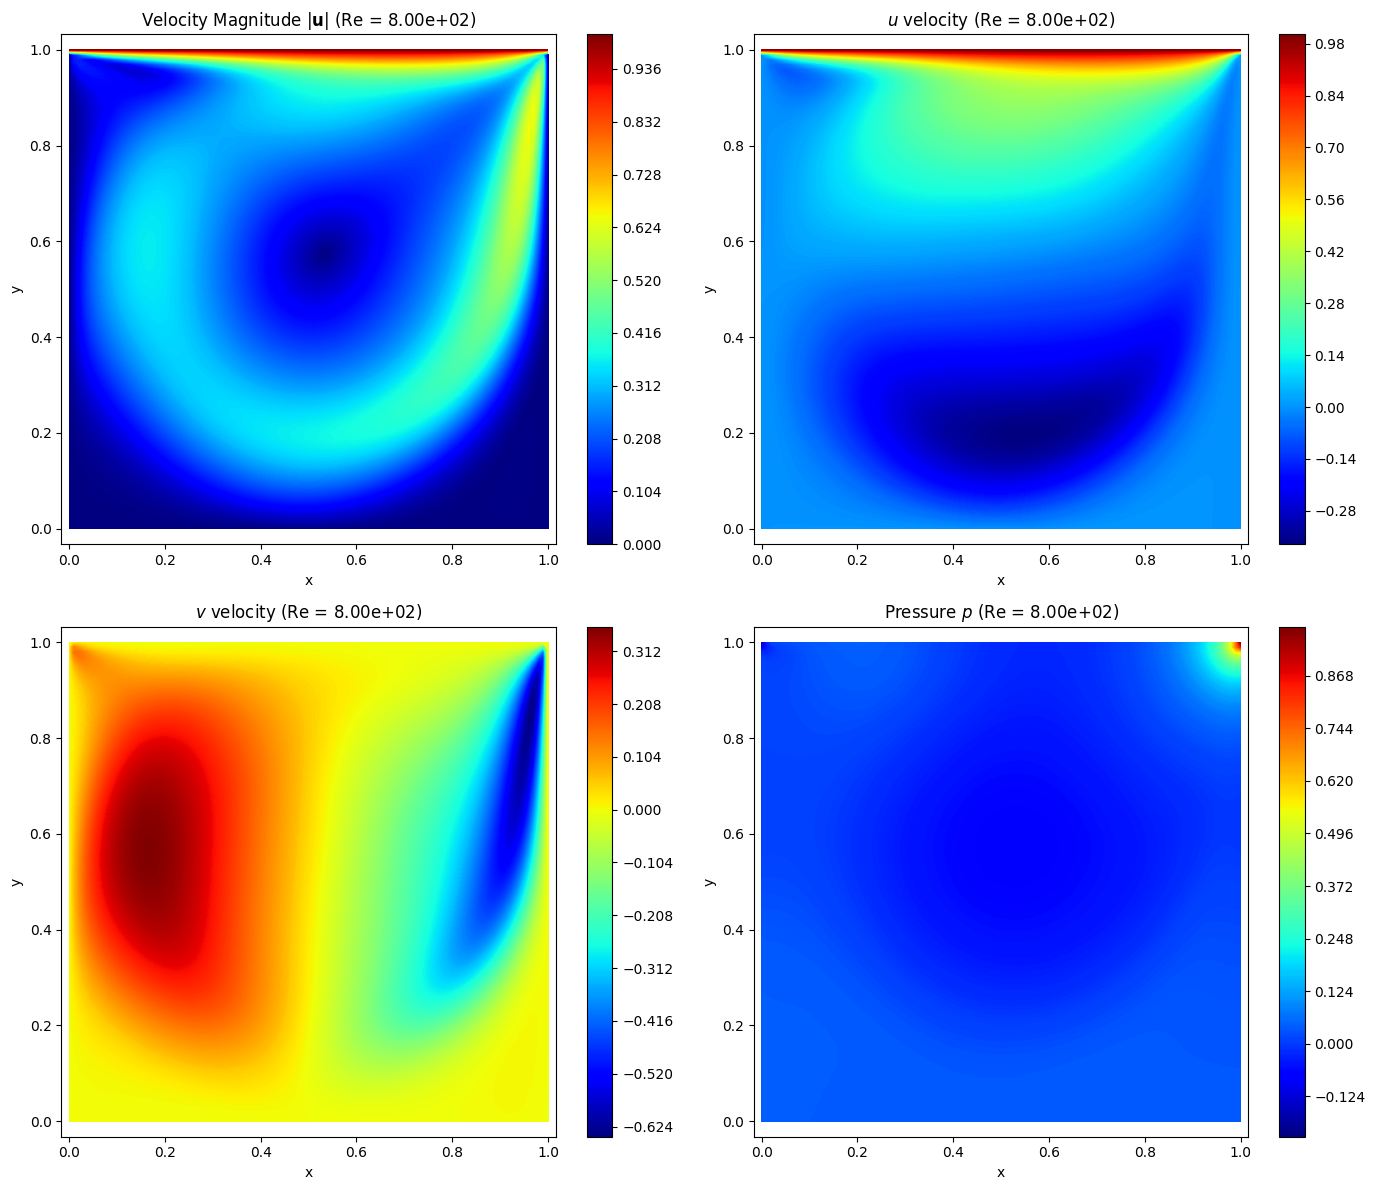

In [6]:

# User interface: Enter Reynolds number
Re_plot = float(input("Enter Reynolds number (Re): "))


# Grid for plotting

Nx, Ny = 101, 101  # grid resolution for plotting
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

Re_val = np.full_like(X, Re_plot)

# Stack grid points into (x, y, Re) tensor
X_input = np.stack(
    [X.flatten(), Y.flatten(), Re_val.flatten()],
    axis=1
)
X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)


# Evaluate model outputs (u, v, p)
u_pred, v_pred, p_pred = model(X_tf, training=False)

u_pred = u_pred.numpy().reshape(Ny, Nx)
v_pred = v_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred - np.mean(p_pred)

# Velocity magnitude
vel_mag = np.sqrt(u_pred**2 + v_pred**2)


# Combined contour plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))


# Velocity magnitude
c0 = axes[0, 0].contourf(X, Y, vel_mag, levels=300, cmap='jet')
fig.colorbar(c0, ax=axes[0, 0])
axes[0, 0].set_title(rf"Velocity Magnitude $|\mathbf{{u}}|$ (Re = {Re_plot:.2e})")
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")
axes[0, 0].axis("equal")


# u-velocity
c1 = axes[0, 1].contourf(X, Y, u_pred, levels=300, cmap='jet')
fig.colorbar(c1, ax=axes[0, 1])
axes[0, 1].set_title(rf"$u$ velocity (Re = {Re_plot:.2e})")
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("y")
axes[0, 1].axis("equal")


# v-velocity
c2 = axes[1, 0].contourf(X, Y, v_pred, levels=300, cmap='jet')
fig.colorbar(c2, ax=axes[1, 0])
axes[1, 0].set_title(rf"$v$ velocity (Re = {Re_plot:.2e})")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel("y")
axes[1, 0].axis("equal")


# Pressure
c3 = axes[1, 1].contourf(X, Y, p_pred, levels=300, cmap='jet')
fig.colorbar(c3, ax=axes[1, 1])
axes[1, 1].set_title(rf"Pressure $p$ (Re = {Re_plot:.2e})")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("y")
axes[1, 1].axis("equal")

plt.tight_layout()
plt.show()


In [ ]:

# Load the CFD data
data_file = fr"DataRe{int(Re_plot)}.csv"   # Choose correct paths for the csv files
cfd_data = pd.read_csv(data_file)

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Extract input and output columns
x_data = cfd_data['x'].values.reshape(-1, 1)
y_data = cfd_data['y'].values.reshape(-1, 1)
inputs = np.hstack((x_data, y_data))

u_data = cfd_data['u'].values.reshape(-1, 1)
v_data = cfd_data['v'].values.reshape(-1, 1)
p_data = cfd_data['p'].values.reshape(-1, 1)
outputs = np.hstack((u_data, v_data, p_data))

xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()

x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)
X, Y = np.meshgrid(x, y)

# Interpolate scattered data onto the grid
U_grid = griddata((x_data.flatten(), y_data.flatten()), u_data.flatten(), (X, Y), method='cubic')
V_grid = griddata((x_data.flatten(), y_data.flatten()), v_data.flatten(), (X, Y), method='cubic')
P_grid = griddata((x_data.flatten(), y_data.flatten()), p_data.flatten(), (X, Y), method='cubic')


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

# Flatten all fields (griddata or predictions may contain NaNs, remove them)
def valid_mask(a, b):
    """Return mask where both arrays are valid (non-NaN)."""
    return ~np.isnan(a.flatten()) & ~np.isnan(b.flatten())

# U field
mask_u = valid_mask(U_grid, u_pred)
U_true = U_grid.flatten()[mask_u]
U_hat = u_pred.flatten()[mask_u]

MSE_U = mean_squared_error(U_true, U_hat)
R2_U  = r2_score(U_true, U_hat)

# V field 
mask_v = valid_mask(V_grid, v_pred)
V_true = V_grid.flatten()[mask_v]
V_hat  = v_pred.flatten()[mask_v]

MSE_V = mean_squared_error(V_true, V_hat)
R2_V  = r2_score(V_true, V_hat)

# P field 
mask_p = valid_mask(P_grid, p_pred)
P_true = P_grid.flatten()[mask_p]
P_hat  = p_pred.flatten()[mask_p]

MSE_P = mean_squared_error(P_true, P_hat)

# Mean-correct pressure for R
P_true_zero = P_true - np.mean(P_true)
P_hat_zero  = P_hat  - np.mean(P_hat)

R2_P = r2_score(P_true_zero, P_hat_zero)

# Print results
print(" MODEL PERFORMANCE ")
print(f"MSE (U): {MSE_U:.6e}")
print(f"R²  (U): {R2_U:.6f}\n")

print(f"MSE (V): {MSE_V:.6e}")
print(f"R²  (V): {R2_V:.6f}\n")

print(f"MSE (P): {MSE_P:.6e}")
print(f"Mean-Corrected R²  (P): {R2_P:.6f}")


 MODEL PERFORMANCE 
MSE (U): 6.154598e-05
R²  (U): 0.998767

MSE (V): 1.230840e-05
R²  (V): 0.999675

MSE (P): 1.645361e-03
Mean-Corrected R²  (P): 0.997949


In [9]:
# Function definition for contour plots of u,v and p
def plot_actual_predicted_error(
    X, Y, actual, predicted, title_actual, title_predicted,title_Error,
    axis_fontsize=14,
    tick_fontsize=12,
    title_fontsize=16,
    cbar_fontsize=12,
    save_path=None  
):
   
    plt.rcParams.update({
        "font.family": "serif",
        "axes.linewidth": 1.2,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
    })

    fig, axs = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)

    # Compute absolute error
    error = np.abs(actual - predicted)

    # Common vmin/vmax for actual & predicted
    vmin = min(np.nanmin(actual), np.nanmin(predicted))
    vmax = max(np.nanmax(actual), np.nanmax(predicted))

    # Actual contours
    contour_actual = axs[0].contourf(X, Y, actual, levels=300, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0].set_title(title_actual, fontsize=title_fontsize)
    axs[0].set_xlabel("x [m]", fontsize=axis_fontsize)
    axs[0].set_ylabel("y [m]", fontsize=axis_fontsize)
    axs[0].tick_params(axis="both", labelsize=tick_fontsize)
    axs[0].text(0.5, -0.20, "(a)", transform=axs[0].transAxes,
                ha="center", va="center", fontsize=title_fontsize)

    # Predicted contours
    contour_predicted = axs[1].contourf(X, Y, predicted, levels=300, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1].set_title(title_predicted, fontsize=title_fontsize)
    axs[1].set_xlabel("x [m]", fontsize=axis_fontsize)
    axs[1].set_ylabel("y [m]", fontsize=axis_fontsize)
    axs[1].tick_params(axis="both", labelsize=tick_fontsize)
    axs[1].text(0.5, -0.20, "(b)", transform=axs[1].transAxes,
                ha="center", va="center", fontsize=title_fontsize)

    # Error contours
    contour_error = axs[2].contourf(X, Y, error, levels=300, cmap="jet")
    axs[2].set_title(title_Error, fontsize=title_fontsize)
    axs[2].set_xlabel("x [m]", fontsize=axis_fontsize)
    axs[2].set_ylabel("y [m]", fontsize=axis_fontsize)
    axs[2].tick_params(axis="both", labelsize=tick_fontsize)
    axs[2].text(0.5, -0.20, "(c)", transform=axs[2].transAxes,
                ha="center", va="center", fontsize=title_fontsize)

    # Shared colorbar for actual & predicted
    cbar = fig.colorbar(contour_actual, ax=axs[0:2], shrink=0.9, pad=0.02, aspect=30)
    cbar.set_label("Value", fontsize=cbar_fontsize)
    cbar.ax.tick_params(labelsize=tick_fontsize)

    # Separate colorbar for error
    cbar_error = fig.colorbar(contour_error, ax=axs[2], shrink=0.9, pad=0.02, aspect=30)
    cbar_error.set_label("Error", fontsize=cbar_fontsize)
    cbar_error.ax.tick_params(labelsize=tick_fontsize)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


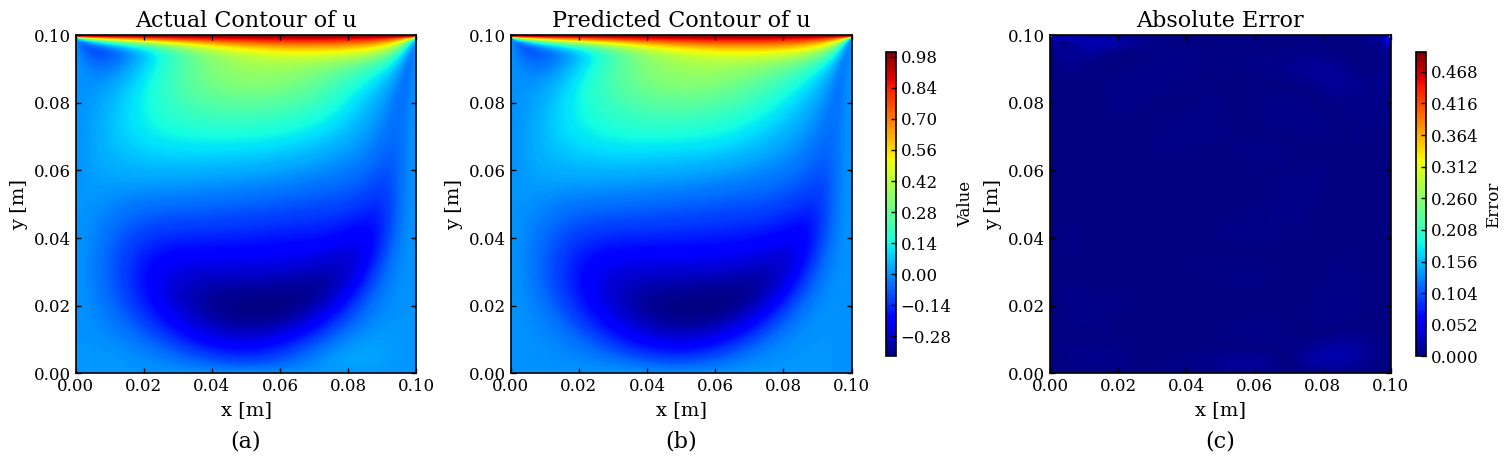

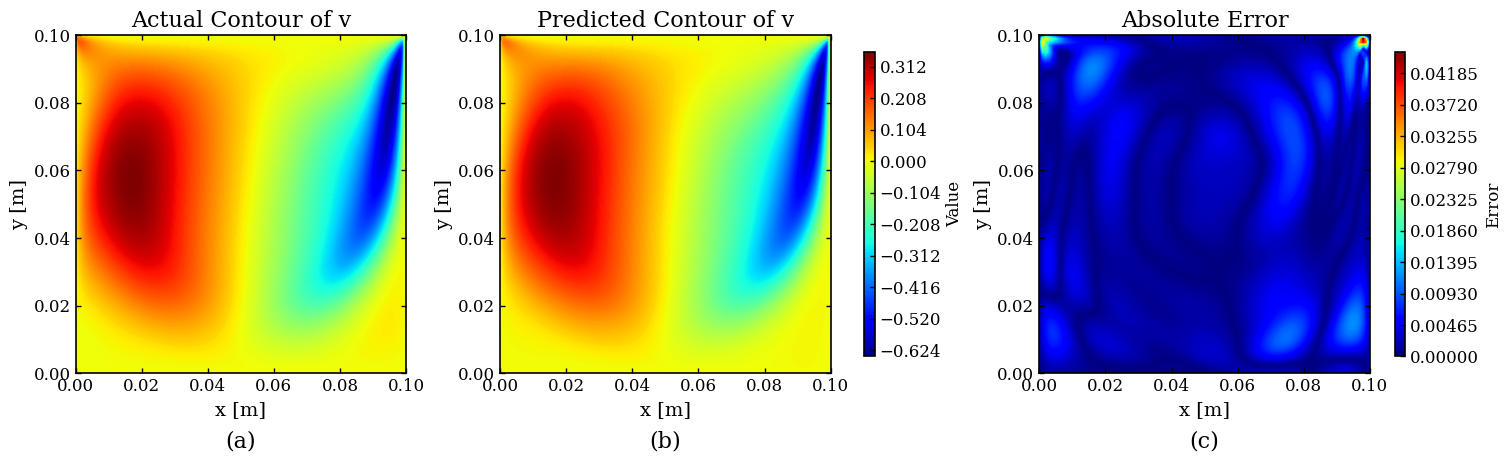

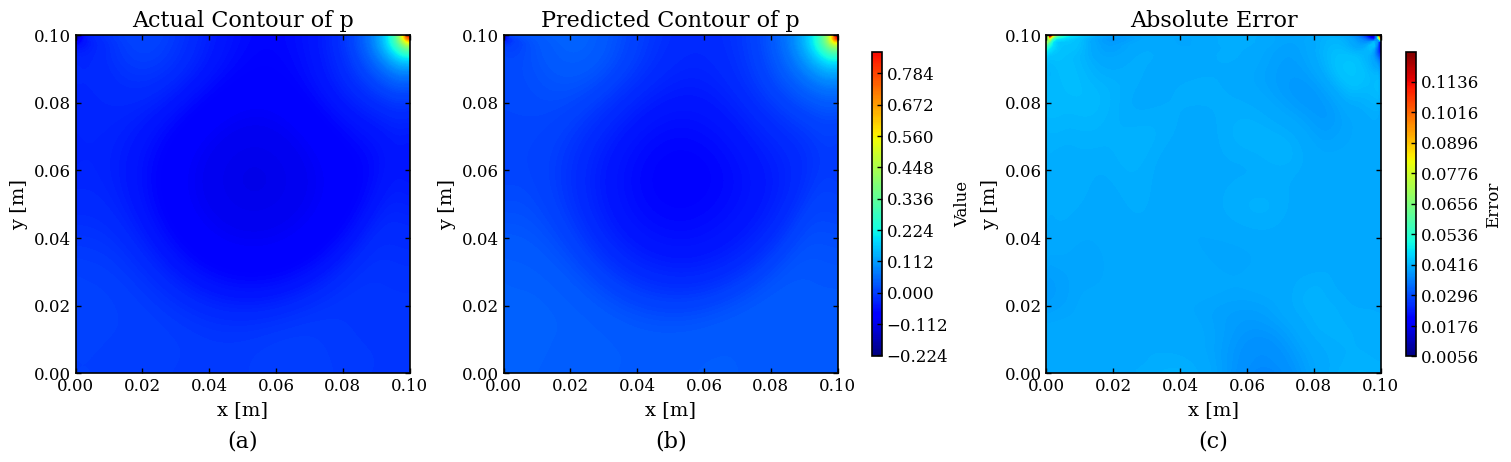

In [10]:
# Plot actual and predicted for u
plot_actual_predicted_error(X, Y, U_grid, u_pred, 'Actual Contour of u', 'Predicted Contour of u','Absolute Error')

# Plot actual and predicted for v
plot_actual_predicted_error(X, Y, V_grid, v_pred, 'Actual Contour of v', 'Predicted Contour of v','Absolute Error')

# Plot actual and predicted for p
plot_actual_predicted_error(X, Y, P_grid, p_pred, 'Actual Contour of p', 'Predicted Contour of p','Absolute Error')



In [11]:
import matplotlib.pyplot as plt
import numpy as np

#  POF STYLE 
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
})


def plot_profiles_multiple_locations_single_plot(
    X, Y, U_grid, V_grid, u_pred, v_pred,
    locations=(0.3, 0.5,0.8),
    font_size=16,
    label_fs=None,
    tick_fs=None,
    legend_fs=None,
    title_fs=None,
    error_stride=5,
    legend_x=0.98,
    legend_y=0.98
):

    # Font fallbacks
    label_fs  = label_fs  or font_size
    tick_fs   = tick_fs   or font_size * 0.8
    legend_fs = legend_fs or font_size * 0.65
    title_fs  = title_fs  or font_size

    xmin, xmax = 0, 1
    nx, ny = U_grid.shape
    x_lin = np.linspace(xmin, xmax, nx)
    y_lin = np.linspace(xmin, xmax, ny)

    fig, ax_vx = plt.subplots(figsize=(7.2, 7.0))

    # Error model
    E = 0.07 # Error bar %

    colors     = ['tab:red', 'tab:blue', 'tab:green']
    markers    = ['o', 's', '^']
    linestyles = ['-', '--', '-.']   

   
    # v(x) at y locations
 
    for i, y0 in enumerate(locations):
        yi = np.abs(y_lin - y0).argmin()
        col, mk, ls = colors[i], markers[i], linestyles[i]

        v_act = V_grid[yi, :]
        v_prd = v_pred[yi, :]
        v_err = np.abs(E * v_act)

        # CFD ( markers )
        ax_vx.plot(
            x_lin, v_act,
            linestyle='none',
            marker=mk, markersize=3,
            markerfacecolor=col,
            markeredgecolor='k',
            label=rf'$v$ CFD, $y={y_lin[yi]:.1f}$'
        )

        # PINNs  ( different line styles )
        ax_vx.plot(
            x_lin, v_prd,
            linestyle=ls,
            lw=0.8,
            color=col,
            label=rf'$v$ PINNs, $y={y_lin[yi]:.1f}$'
        )

        step = slice(0, len(x_lin), error_stride)
        ax_vx.errorbar(
            x_lin[step], v_prd[step],
            yerr=v_err[step],
            fmt='none',
            ecolor=col,
            capsize=3
        )

    ax_vx.set_xlabel(r'$x$', fontsize=label_fs)
    ax_vx.set_ylabel(r'$v$', fontsize=label_fs)
    ax_vx.set_xlim(0, 1)
    ax_vx.set_ylim(-1.0, 1.0)
    ax_vx.tick_params(labelsize=tick_fs)


    # Right axis: y

    ax_y = ax_vx.twinx()
    ax_y.set_ylabel(r'$y$', fontsize=label_fs)
    ax_y.set_ylim(0, 1)
    ax_y.tick_params(labelsize=tick_fs)

 
    # Top axis: u(y) at x locations
 
    ax_u = ax_y.twiny()

    for i, x0 in enumerate(locations):
        xi = np.abs(x_lin - x0).argmin()
        col, mk, ls = colors[i], markers[i], linestyles[i]

        u_act = U_grid[:, xi]
        u_prd = u_pred[:, xi]
        u_err = np.abs(E * u_act)

        # CFD ( markers )
        ax_u.plot(
            u_act, y_lin,
            linestyle='none',
            marker=mk, markersize=3,
            markerfacecolor=col,
            markeredgecolor='k',
            label=rf'$u$ CFD, $x={x_lin[xi]:.1f}$'
        )

        # PINNs ( different line styles )
        ax_u.plot(
            u_prd, y_lin,
            linestyle=ls,
            lw=0.8,
            color=col,
            label=rf'$u$ PINNs, $x={x_lin[xi]:.1f}$'
        )

        step = slice(0, len(y_lin), error_stride)
        ax_u.errorbar(
            u_prd[step], y_lin[step],
            xerr=u_err[step],
            fmt='none',
            ecolor=col,
            capsize=3
        )

    ax_u.set_xlabel(r'$u$', fontsize=label_fs)
    ax_u.set_xlim(-1.0, 1.0)
    ax_u.tick_params(labelsize=tick_fs)

    # Legend

    hv, lv = ax_vx.get_legend_handles_labels()
    hu, lu = ax_u.get_legend_handles_labels()

    ax_vx.legend(
        hv + hu,
        lv + lu,
        fontsize=legend_fs,
        loc='upper right',
        bbox_to_anchor=(legend_x, legend_y),
        frameon=False
    )

    plt.tight_layout()
    plt.show()


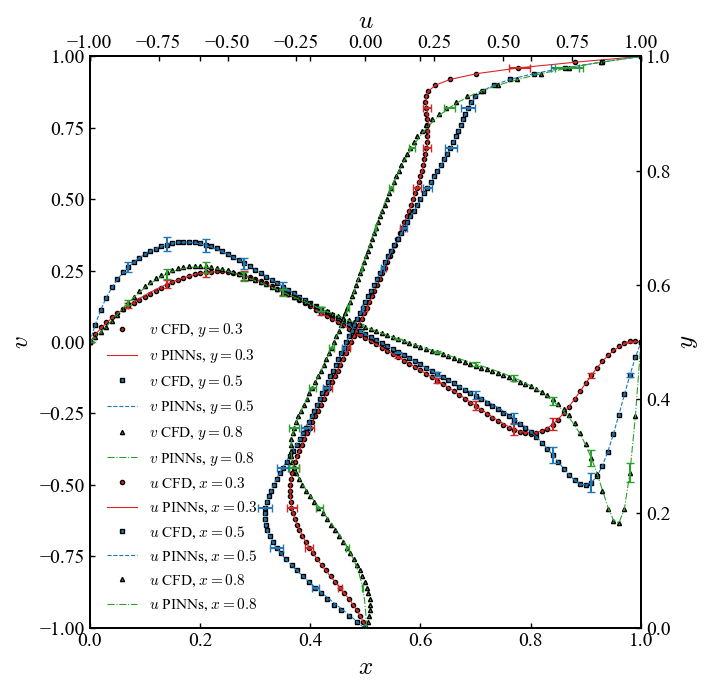

In [12]:
# Velocity profile plots

plot_profiles_multiple_locations_single_plot(
    X, Y,
    U_grid, V_grid,
    u_pred, v_pred,
    locations=(0.3, 0.5,0.8),
    font_size=16,
    label_fs=18,
    tick_fs=14,
    legend_fs=11,
    title_fs=16,
    error_stride=7,
    legend_x=0.33,
    legend_y=0.56
)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter  

# Contiur plot in POF style

def plot_actual_predicted_error(
    X, Y, actual, predicted, title_actual, title_predicted,
    axis_fontsize=24,
    tick_fontsize=24,
    title_fontsize=26,
    cbar_fontsize=26,
    save_path=None  
):
    
    plt.rcParams.update({
        "font.family": "serif",
        "axes.linewidth": 1.2,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
    })

    fig, axs = plt.subplots(1, 3, figsize=(15, 4.2), constrained_layout=True)

    # Compute absolute error
    error = np.abs(actual - predicted)

    # Common vmin/vmax for actual & predicted
    vmin = min(np.nanmin(actual), np.nanmin(predicted))
    vmax = max(np.nanmax(actual), np.nanmax(predicted))
    

    # Actual
    contour_actual = axs[0].contourf(X, Y, actual, levels=300, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0].set_title(title_actual, fontsize=title_fontsize)
    axs[0].set_xlabel("x ", fontsize=axis_fontsize)
    axs[0].set_ylabel("y ", fontsize=axis_fontsize)
    axs[0].tick_params(axis="both", labelsize=tick_fontsize)


    # Predicted
    contour_predicted = axs[1].contourf(X, Y, predicted, levels=300, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1].set_title(title_predicted, fontsize=title_fontsize)
    axs[1].set_xlabel("x ", fontsize=axis_fontsize)
    axs[1].set_ylabel("y ", fontsize=axis_fontsize)
    axs[1].tick_params(axis="both", labelsize=tick_fontsize)


    # Error
    contour_error = axs[2].contourf(X, Y, error, levels=300, cmap="jet")
    axs[2].set_xlabel("x ", fontsize=axis_fontsize)
    axs[2].set_ylabel("y ", fontsize=axis_fontsize)
    axs[2].tick_params(axis="both", labelsize=tick_fontsize)

    # Shared colorbar for actual & predicted
    cbar = fig.colorbar(contour_actual, ax=axs[0:2], shrink=0.9, pad=0.02, aspect=30)
    cbar.ax.tick_params(labelsize=tick_fontsize)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # <-- set 2 decimals


    # Separate colorbar for error
    cbar_error = fig.colorbar(contour_error, ax=axs[2], shrink=0.9, pad=0.02, aspect=30)
    cbar_error.ax.tick_params(labelsize=tick_fontsize)
    cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # <-- set 2 decimals

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


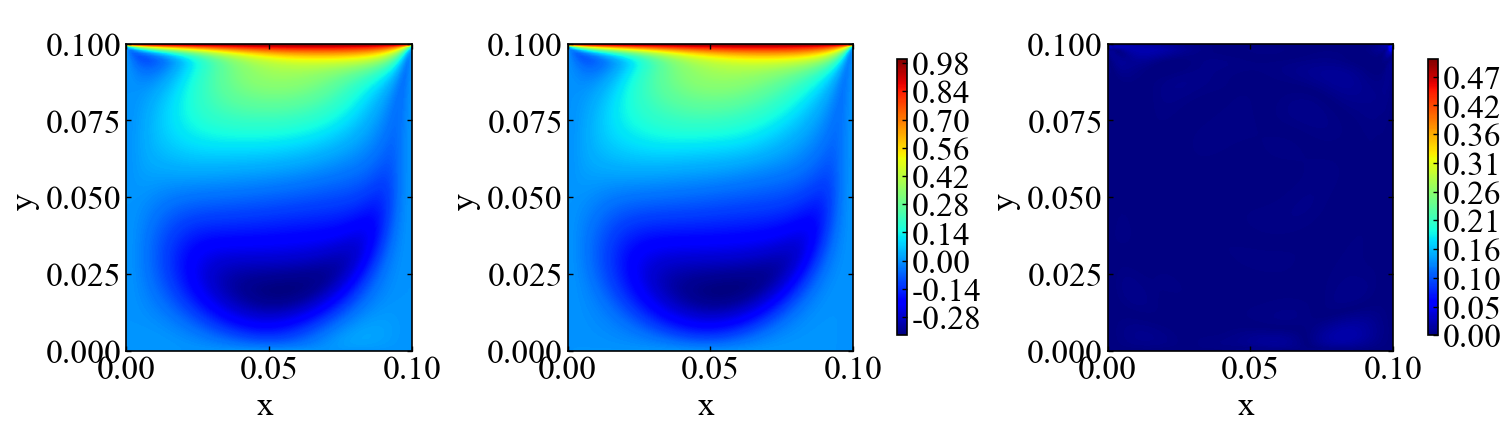

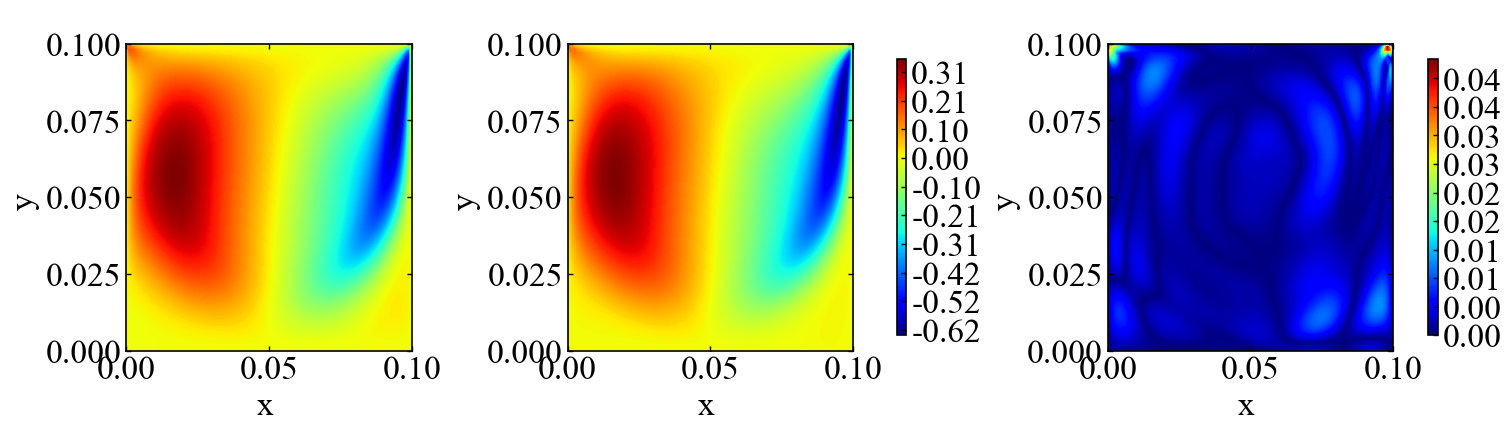

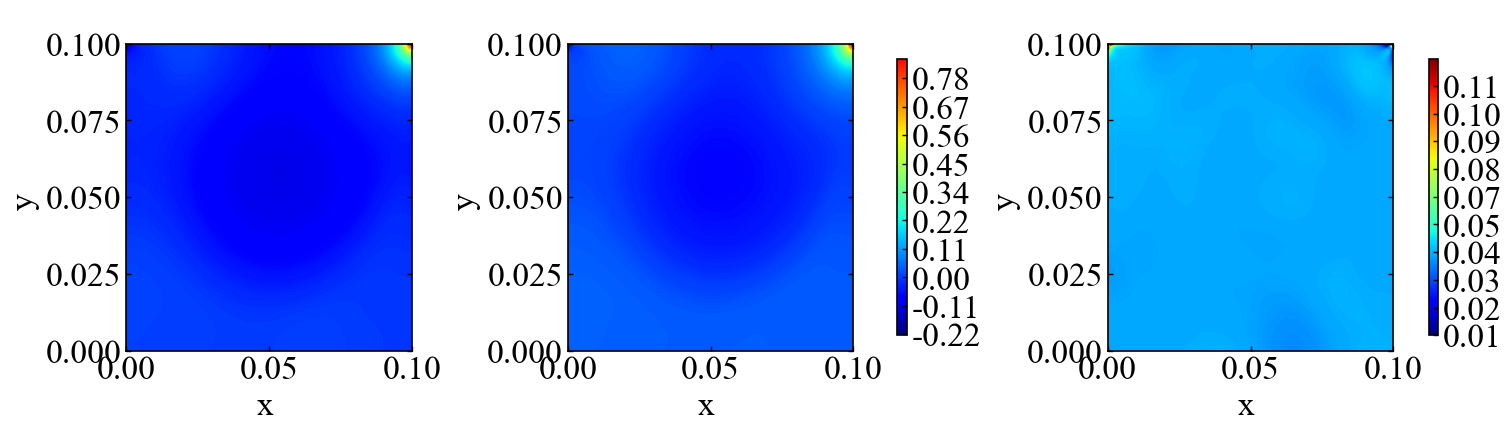

In [14]:
# Plot actual and predicted for u
plot_actual_predicted_error(X,Y, U_grid, u_pred, ' ', ' ')

# Plot actual and predicted for v
plot_actual_predicted_error(X,Y, V_grid, v_pred,' ', ' ')

# Plot actual and predicted for p
plot_actual_predicted_error(X,Y, P_grid, p_pred, ' ', ' ')

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score


# Enter multiple Reynolds numbers to compare MSE ans R2

Re_list = input("Enter Re values (comma-separated): ")
Re_list = [float(r.strip()) for r in Re_list.split(",")]


# Storage containers
MSE_U_arr, R2_U_arr = [], []
MSE_V_arr, R2_V_arr = [], []
MSE_P_arr, R2_P_arr = [], []


# Loop over Reynolds numbers

for Re_plot in Re_list:

    # Load CFD data
    data_file = fr"DataRe{int(Re_plot)}.csv"   # Choose correct paths for the csv files
    cfd_data = pd.read_csv(data_file)

    x = cfd_data['x'].values.reshape(-1, 1)
    y = cfd_data['y'].values.reshape(-1, 1)

    u_true = cfd_data['u'].values
    v_true = cfd_data['v'].values
    p_true = cfd_data['p'].values

    # Normalize coordinates EXACTLY as training
    x_n = (x - x.min()) / (x.max() - x.min())
    y_n = (y - y.min()) / (y.max() - y.min())

    Re_col = np.full_like(x_n, Re_plot)

    X_input = np.hstack([x_n, y_n, Re_col])
    X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)

    # Model prediction
    u_pred, v_pred, p_pred = model(X_tf, training=False)

    u_pred = u_pred.numpy().flatten()
    v_pred = v_pred.numpy().flatten()
    p_pred = p_pred.numpy().flatten()


    # Metrics

    MSE_U = mean_squared_error(u_true, u_pred)
    R2_U  = r2_score(u_true, u_pred)

    MSE_V = mean_squared_error(v_true, v_pred)
    R2_V  = r2_score(v_true, v_pred)

    # Pressure (mean corrected)
    p_true_z = p_true - np.mean(p_true)
    p_pred_z = p_pred - np.mean(p_pred)

    MSE_P = mean_squared_error(p_true_z, p_pred_z)
    R2_P  = r2_score(p_true_z, p_pred_z)
 
    # Store
 
    MSE_U_arr.append(MSE_U)
    R2_U_arr.append(R2_U)

    MSE_V_arr.append(MSE_V)
    R2_V_arr.append(R2_V)

    MSE_P_arr.append(MSE_P)
    R2_P_arr.append(R2_P)
 
# Convert to NumPy arrays
 
MSE_U_arr = np.array(MSE_U_arr)
R2_U_arr  = np.array(R2_U_arr)

MSE_V_arr = np.array(MSE_V_arr)
R2_V_arr  = np.array(R2_V_arr)

MSE_P_arr = np.array(MSE_P_arr)
R2_P_arr  = np.array(R2_P_arr)

 
# Print summary
 
print("\n SUMMARY ")
for i, Re in enumerate(Re_list):
    print(
        f"Re={int(Re):4d} | "
        f"MSE_U={MSE_U_arr[i]:.3e}, R2_U={R2_U_arr[i]:.4f} | "
        f"MSE_V={MSE_V_arr[i]:.3e}, R2_V={R2_V_arr[i]:.4f} | "
        f"MSE_P={MSE_P_arr[i]:.3e}, R2_P={R2_P_arr[i]:.4f}"
    )


# Reynolds numbers
Re = np.array(Re_list, dtype=int)

# Mean Squared Error arrays
MSE_u = np.array(MSE_U_arr, dtype=float)
MSE_v = np.array(MSE_V_arr, dtype=float)
MSE_p = np.array(MSE_P_arr, dtype=float)

# R2 score arrays
R2_u = np.array(R2_U_arr, dtype=float)
R2_v = np.array(R2_V_arr, dtype=float)
R2_p = np.array(R2_P_arr, dtype=float)



 SUMMARY 
Re= 200 | MSE_U=2.543e-03, R2_U=0.9490 | MSE_V=3.485e-03, R2_V=0.8755 | MSE_P=2.305e-03, R2_P=0.5103
Re= 300 | MSE_U=9.076e-04, R2_U=0.9818 | MSE_V=1.784e-03, R2_V=0.9437 | MSE_P=1.276e-03, R2_P=0.6355
Re= 400 | MSE_U=5.228e-04, R2_U=0.9896 | MSE_V=8.644e-04, R2_V=0.9746 | MSE_P=5.210e-04, R2_P=0.8256
Re= 500 | MSE_U=2.402e-04, R2_U=0.9952 | MSE_V=3.259e-04, R2_V=0.9909 | MSE_P=1.358e-04, R2_P=0.9497
Re= 600 | MSE_U=8.670e-05, R2_U=0.9983 | MSE_V=9.596e-05, R2_V=0.9974 | MSE_P=2.253e-05, R2_P=0.9910
Re= 700 | MSE_U=6.962e-05, R2_U=0.9986 | MSE_V=2.734e-05, R2_V=0.9993 | MSE_P=8.314e-06, R2_P=0.9965
Re= 800 | MSE_U=6.155e-05, R2_U=0.9988 | MSE_V=1.231e-05, R2_V=0.9997 | MSE_P=4.569e-06, R2_P=0.9979
Re= 900 | MSE_U=8.506e-05, R2_U=0.9983 | MSE_V=2.548e-05, R2_V=0.9993 | MSE_P=6.318e-06, R2_P=0.9970
Re=1000 | MSE_U=1.857e-04, R2_U=0.9962 | MSE_V=7.824e-05, R2_V=0.9979 | MSE_P=1.472e-05, R2_P=0.9925
Re=1200 | MSE_U=5.682e-04, R2_U=0.9880 | MSE_V=2.898e-04, R2_V=0.9922 | MSE_P=3.

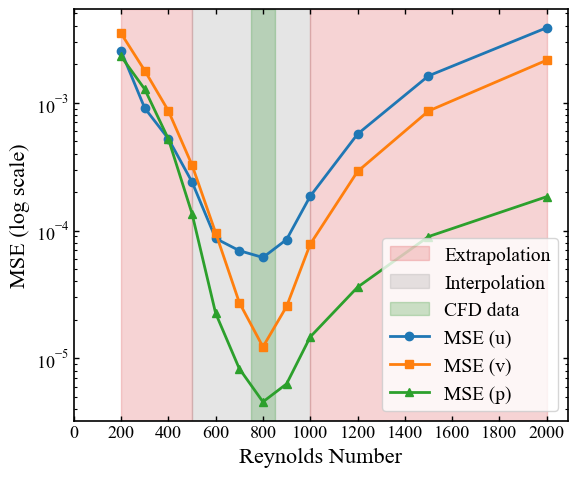

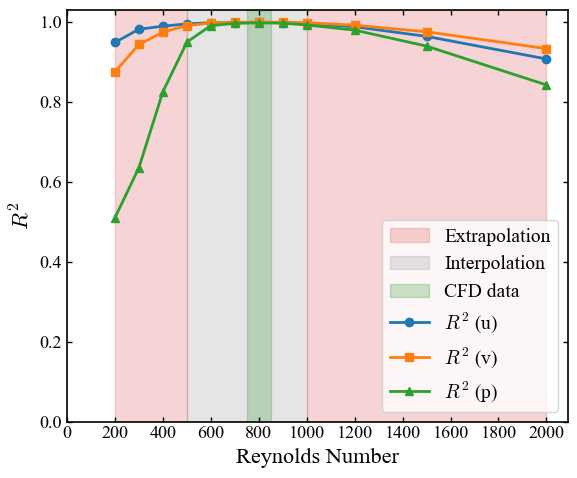

In [16]:

# PoF-style formatting
plt.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "lines.linewidth": 2,
    "figure.figsize": (8, 5),
})

# Region limits
Re_interp_min = Re_min  # Minimum Re in the training range
Re_interp_max = Re_max  # Maximum Re in the training range
Re_data_min = 750       # Minimum Re of the CFD data in the training range
Re_data_max = 850       # Maximum Re of the CFD data in the training range 

# MSE Plot

plt.figure(figsize=(6,5))

# Shaded regions
plt.axvspan(Re.min(), Re_interp_min, color='tab:red', alpha=0.20, label='Extrapolation')
plt.axvspan(Re_interp_min, Re_interp_max, color='gray', alpha=0.20, label='Interpolation')
plt.axvspan(Re_data_min, Re_data_max, color='green', alpha=0.20, label='CFD data')
plt.axvspan(Re_interp_max, Re.max(), color='tab:red', alpha=0.20)

# Curves
plt.semilogy(Re, MSE_u, marker='o', label='MSE (u)')
plt.semilogy(Re, MSE_v, marker='s', label='MSE (v)')
plt.semilogy(Re, MSE_p, marker='^', label='MSE (p)')

plt.xlabel('Reynolds Number')
plt.ylabel('MSE (log scale)')


# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
Re_ticks = np.arange(0, 2001, 200)   
plt.xticks(Re_ticks)

plt.tight_layout()
plt.show()


# R² Plot

plt.figure(figsize=(6,5))

# Shaded regions
plt.axvspan(Re.min(), Re_interp_min, color='tab:red', alpha=0.20, label='Extrapolation')
plt.axvspan(Re_interp_min, Re_interp_max, color='gray', alpha=0.20, label='Interpolation')
plt.axvspan(Re_data_min, Re_data_max, color='green', alpha=0.20, label='CFD data')
plt.axvspan(Re_interp_max, Re.max(), color='tab:red', alpha=0.20)

# Curves
plt.plot(Re, R2_u, marker='o', label=r'$R^{2}$ (u)')
plt.plot(Re, R2_v, marker='s', label=r'$R^{2}$ (v)')
plt.plot(Re, R2_p, marker='^', label=r'$R^{2}$ (p)')

plt.xlabel('Reynolds Number')
plt.ylabel(r'$R^{2}$')
plt.xticks(Re_ticks)
plt.ylim(0.0, 1.03)


# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()
